In [49]:
# !pip install pyro-ppl
#!pwd
#!pip install matplotlib
# !pip install pyro-ppl pandas numpy scikit-learn torch

# Adding Hierachal intercepts by state and Heteroscedastic σ modeled by a small MLP on top of SVI vars

Hierarchical intercepts by state:
- instead of a single global intercept, each state gets its own baseline damage shift, drawn from a shared distribution
- counties in states with little data borrow strength from the whole: their intercepts shrink toward the overall mean
- hoping that this captures unobserved regional factors (building codes, local policies, coast vs inland) that previousflat model couldn’t

Heteroscedastic σ using a small MLP:
- instead of assuming every county’s damage has the same noise (σ), let a neural net learn σ(x) as a positive function of the predictors
- high‑vulnerability profiles (e.g. dense poverty, mobile homes) can have much wider error bars, and the model will learn that
- hoping this improves both the fit (by matching the true spread) and uncertainty estimates (wider credible bands where data are noisier)

**Notes: We still need to check if and how much were the results improved**


**The intercept is hierarchical by state. The heteroscedastic σ is a single global MLP (multi layer perceptron) – it takes each county’s feature vector and spits out a noise scale, but it does not vary by state except the features themselves encode state‐level information. We can add per‑state σ‑offset on top of the MLP. It might be better to look at the effects of first just Hierachial and then just Heteroscedastic**


**Also, look into this warning /opt/anaconda3/envs/cos513/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn (only get it for partial dependence plots)**


**I didn't do any cross validation here since the data range is from 2010-2022 (small), will use it for spatial model)**



In [7]:
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from pyro.nn import PyroModule


In [8]:
# Column Mapping & Data Loading

census_svi_column_mapping = {
    'B01001_001E': 'Total Population',
    'B19001_001E': 'Household Income Distribution',
    'B19013_001E': 'Median Household Income',
    'B19001_002E': 'Income Bracket 1',
    'B19001_003E': 'Income Bracket 2',
    'B19001_004E': 'Income Bracket 3',
    'B19001_005E': 'Income Bracket 4',
    'B19001_006E': 'Income Bracket 5',
    'B19001_007E': 'Income Bracket 6',
    'B19001_008E': 'Income Bracket 7',
    'B19001_009E': 'Income Bracket 8',
    'B19001_010E': 'Income Bracket 9',
    'B19001_011E': 'Income Bracket 10',
    'B19001_012E': 'Income Bracket 11',
    'B19001_013E': 'Income Bracket 12',
    'B19001_014E': 'Income Bracket 13',
    'B19001_015E': 'Income Bracket 14',
    'B19001_016E': 'Income Bracket 15',
    'B19001_017E': 'Income Bracket 16',
    'state': 'State',
    'county': 'County',
    'tract': 'Census Tract',
    'year': 'Year',
    'STATE_COUNTY_FIPS': 'State-County FIPS Code',
    'GEOID': 'Geographic Identifier',
    'FIPS': 'FIPS Code',
    'RPL_THEMES': 'SVI Themes',
    'CZ_FIPS': 'Combined Statistical Area FIPS',
    'ST': 'State Abbreviation',
    'LOCATION': 'Location',
    'E_TOTPOP': 'Estimated Total Population',
    'M_TOTPOP': 'Margin of Error Total Population',
    'E_HU': 'Estimated Housing Units',
    'M_HU': 'Margin of Error Housing Units',
    'E_UNEMP': 'Estimated Unemployed',
    'M_UNEMP': 'Margin of Error Unemployed',
    'E_LIMENG': 'Estimated Limited English Proficiency',
    'M_LIMENG': 'Margin of Error Limited English Proficiency',
    'E_MUNIT': 'Estimated Multi-Unit Housing',
    'M_MUNIT': 'Margin of Error Multi-Unit Housing',
    'E_MOBILE': 'Estimated Mobile Homes',
    'M_MOBILE': 'Margin of Error Mobile Homes',
    'E_CROWD': 'Estimated Crowded Housing',
    'M_CROWD': 'Margin of Error Crowded Housing',
    'E_NOVEH': 'Estimated No Vehicle',
    'M_NOVEH': 'Margin of Error No Vehicle',
    'DAMAGE_PROPERTY': 'Damage to Property',
    'DAMAGE_CROPS': 'Damage to Crops',
    'BEGIN_YEARMONTH': 'Begin Year-Month',
    'LAT': 'Latitude',
    'LON': 'Longitude',
    'storm_county': 'Storm County'
}

def load_hurricane_data():
    dfs = []
    for year in range(2010, 2023):
        path = f'../data/df_clean/df_hurricane_{year}.csv'
        try:
            df = pd.read_csv(path)
            df = df.rename(columns=census_svi_column_mapping)
            df['Year'] = year
            dfs.append(df)
        except FileNotFoundError:
            print(f" Skipping {year}: file not found")
    full = pd.concat(dfs, ignore_index=True)
    print(f" Loaded full_data with shape: {full.shape}")
    return full

In [9]:
# Adding features
def add_features(df):
    # vulnerability ratios
    df['pct_unemp']    = df['Estimated Unemployed']   / df['Total Population']
    df['pct_limm']     = df['Estimated Limited English Proficiency'] / df['Total Population']
    df['pct_noveh']    = df['Estimated No Vehicle']   / df['Total Population']
    # housing vulnerability
    df['pct_mobile']   = df['Estimated Mobile Homes'] / df['Estimated Housing Units']
    df['pct_crowd']    = df['Estimated Crowded Housing'] / df['Estimated Housing Units']
    # income‐distribution summaries
    lows  = [f'Income Bracket {i}' for i in (1,2,3)]
    highs = [f'Income Bracket {i}' for i in (14,15,16)]
    df['low_inc_pct']  = df[lows].sum(axis=1) / df['Household Income Distribution']
    df['high_inc_pct'] = df[highs].sum(axis=1) / df['Household Income Distribution']
    df['inc_ineq']     = df['high_inc_pct'] / (df['low_inc_pct'] + 1e-6)
    # log‐transforms
    df['log_pop']      = np.log1p(df['Total Population'])
    df['log_medinc']   = np.log1p(df['Median Household Income'])
    # seasonality
    df['Begin Year-Month'] = pd.to_datetime(df['Begin Year-Month'], format='%Y%m')
    df['month']         = df['Begin Year-Month'].dt.month
    # interaction
    df['pop_poverty']   = df['Total Population'] * df['low_inc_pct']
    return df


 Loaded full_data with shape: (185925, 52)
Epoch 100 | Train=392283.5 | Test=79415.8
Epoch 200 | Train=256124.0 | Test=62514.7
Epoch 300 | Train=233855.7 | Test=56992.7
Epoch 400 | Train=207485.4 | Test=49804.3
Epoch 500 | Train=209444.6 | Test=48650.8
Epoch 600 | Train=216939.2 | Test=47317.7
Epoch 700 | Train=201717.4 | Test=45481.2
Epoch 800 | Train=199449.3 | Test=45361.6
Epoch 900 | Train=202186.5 | Test=43038.4
Epoch 1000 | Train=197717.7 | Test=44262.1


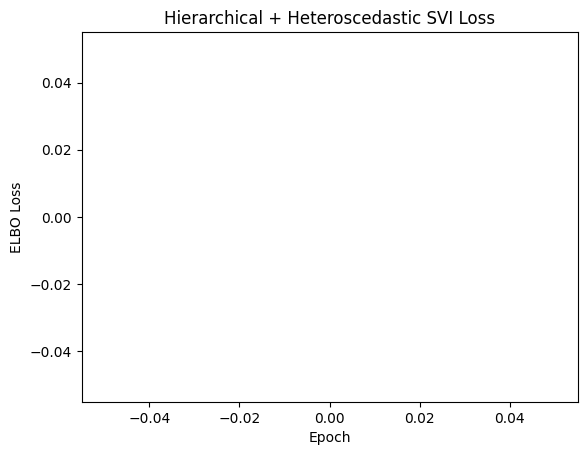

In [23]:
# Prepare features + grouping

def prepare_features_and_group(df, feature_list, group_col):
    # drop rows with NA in features or target
    df = df.dropna(subset=feature_list + ['Damage to Property', group_col])
    # 1) X, y
    X = df[feature_list].values
    y = np.log1p(df['Damage to Property'].values)
    # 2) group index (e.g. state codes)
    cats = pd.Categorical(df[group_col])
    group_idx = cats.codes  # 0 … (n_groups-1)
    return X, y, group_idx, cats.categories

# Pipeline
full = load_hurricane_data()
full = add_features(full)

features = [
    'log_pop','log_medinc',
    'pct_unemp','pct_limm','pct_noveh',
    'low_inc_pct','high_inc_pct','inc_ineq',
    'month','pop_poverty'
]

# split raw frames
raw_train = full[full['Year'] < 2022].reset_index(drop=True)
raw_test  = full[full['Year'] == 2022].reset_index(drop=True)

# prepare X, y, and state indices
X_train, y_train, state_idx_train, state_categories = prepare_features_and_group(
    raw_train, features, group_col='State Abbreviation'
)
X_test, y_test, state_idx_test, _ = prepare_features_and_group(
    raw_test, features, group_col='State Abbreviation'
)

n_states   = len(state_categories)
n_features = len(features)

# scale 
scaler         = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# tensors
X_train_t      = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t      = torch.tensor(y_train,          dtype=torch.float32)
state_idx_t    = torch.tensor(state_idx_train,  dtype=torch.long)
X_test_t       = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_test_t       = torch.tensor(y_test,         dtype=torch.float32)
state_idx_test = torch.tensor(state_idx_test,   dtype=torch.long)

# Define heteroscedastic net
class HeteroNet(PyroModule):
    def __init__(self, in_dim, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Softplus(),
            nn.Linear(hidden, 1),
            nn.Softplus()
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

hetero_net = HeteroNet(n_features)
pyro.module("hetero_net", hetero_net)

# Pyro model & guide
def model(X, state_idx, y=None):
    # hyperprior for state‐offset sd
    sigma_state = pyro.sample("sigma_state", dist.HalfCauchy(5.0))
    with pyro.plate("states", n_states):
        state_offsets = pyro.sample("state_offsets", dist.Normal(0.0, sigma_state)) # we sample on specific state
    # global intercept
    intercept = pyro.sample("intercept", dist.Normal(0., 10.))
    # global weights
    weights = pyro.sample(
        "weights",
        dist.Normal(torch.zeros(n_features), 10 * torch.ones(n_features)).to_event(1)
    )
    # conditional mean
    mu = intercept + state_offsets[state_idx] + (X * weights).sum(dim=-1)
    # heteroscedastic sigma
    sigma = hetero_net(X) #where hetero_net is a small neural net shared across all states
    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=y)

from pyro.nn import PyroModule  # make sure this import is present

def guide(X, state_idx, y=None):
    # σ_state’s variational Delta
    sigma_state_loc = pyro.param(
        "sigma_state_loc", torch.tensor(1.0),
        constraint=dist.constraints.positive
    )
    pyro.sample("sigma_state", dist.Delta(sigma_state_loc))
    
    # draw each state’s offset under the same plate
    with pyro.plate("states", n_states):
        state_loc  = pyro.param("state_offsets_loc",   torch.zeros(n_states))
        state_scale= pyro.param("state_offsets_scale", torch.ones(n_states),
                                 constraint=dist.constraints.positive)
        pyro.sample("state_offsets",
                    dist.Normal(state_loc, state_scale))
    
    # global intercept
    i_loc   = pyro.param("intercept_loc",  torch.tensor(0.0))
    i_scale = pyro.param("intercept_scale",torch.tensor(1.0),
                         constraint=dist.constraints.positive)
    pyro.sample("intercept", dist.Normal(i_loc, i_scale))
    
    # global weights
    w_loc   = pyro.param("weights_loc",   torch.zeros(n_features))
    w_scale = pyro.param("weights_scale", torch.ones(n_features),
                         constraint=dist.constraints.positive)
    pyro.sample("weights",
                dist.Normal(w_loc, w_scale).to_event(1))


# Train with SVI
pyro.clear_param_store()
optimizer = Adam({"lr": 0.005})
svi       = SVI(model, guide, optimizer, loss=Trace_ELBO())
train_losses = []
test_losses  = []
n_epochs     = 1000  
losses = []
for epoch in range(1, n_epochs+1):
    tl = svi.step(X_train_t, state_idx_t, y_train_t)
    vl = svi.evaluate_loss(X_test_t, state_idx_test, y_test_t)
    train_losses.append(tl)
    test_losses .append(vl)
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train={tl:.1f} | Test={vl:.1f}")

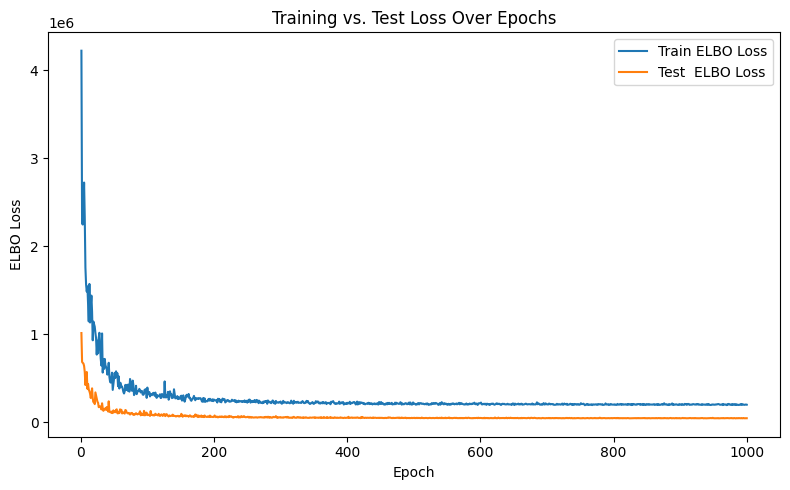

In [24]:
# Plot loss curves
epochs = range(1, n_epochs+1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train ELBO Loss')
plt.plot(epochs, test_losses,  label='Test  ELBO Loss')
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.title('Training vs. Test Loss Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()


## Analysis

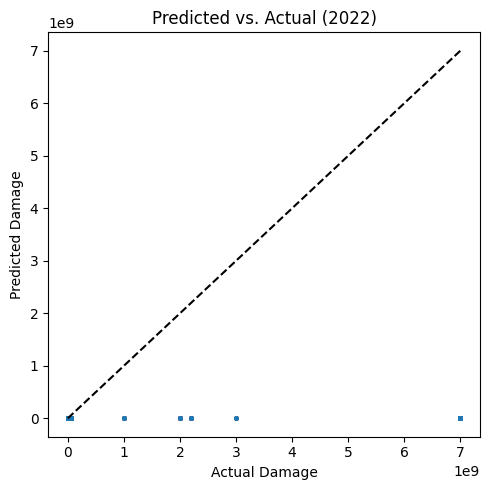

In [15]:
# Predicted vs. Actual scatter 
# Note: this doesn't make much sense here since we are predicitng only 1 year
# reconstruct point predictions
b0 = pyro.param("intercept_loc").item()
w  = pyro.param("weights_loc").detach().numpy()
y_pred = np.expm1(b0 + X_test_t.numpy() @ w)
y_true = np.expm1(y_test_t.numpy())

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.3, s=5)
lims = [y_true.min(), y_true.max()]
plt.plot(lims, lims, 'k--')  # 45° line
plt.xlabel("Actual Damage")
plt.ylabel("Predicted Damage")
plt.title("Predicted vs. Actual (2022)")
plt.tight_layout()
plt.show()


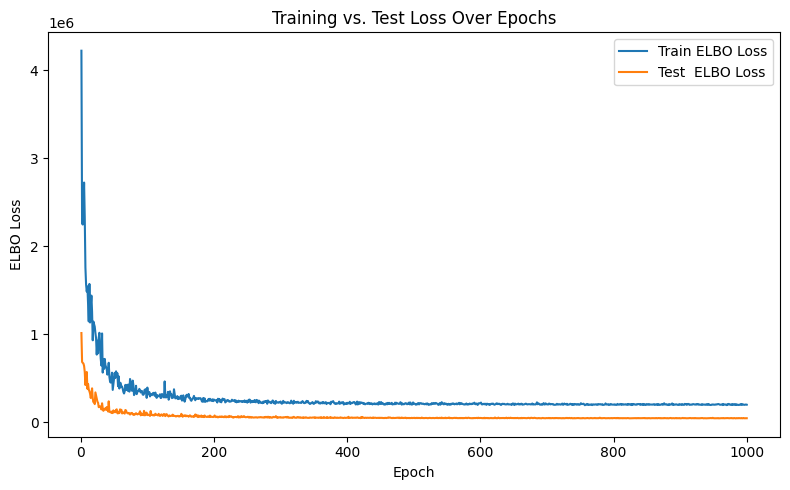

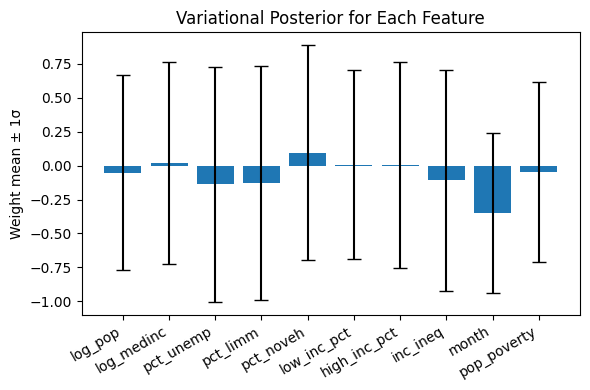

/opt/anaconda3/envs/cos513/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


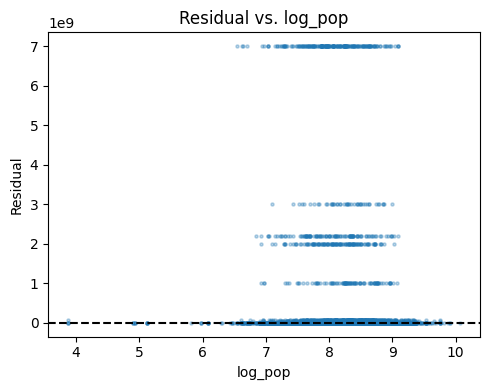

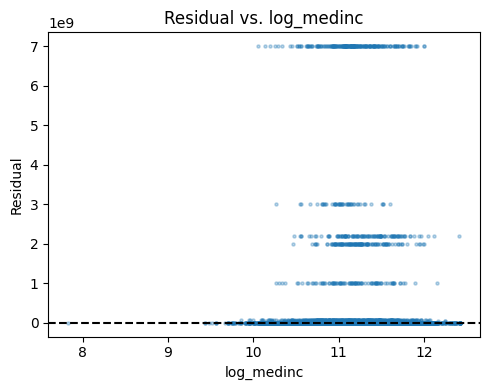

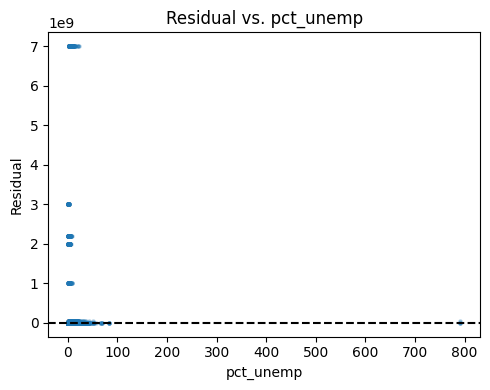

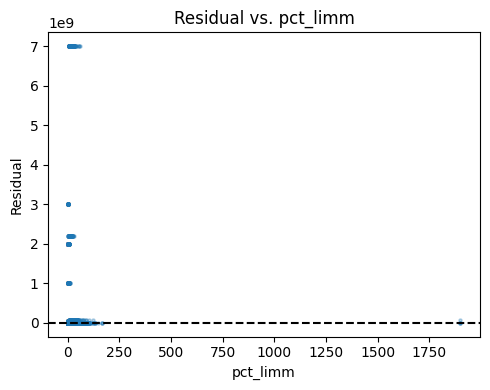

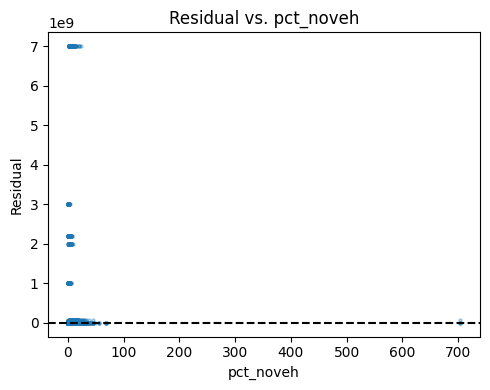

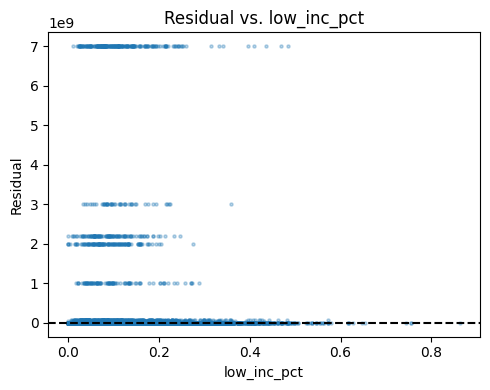

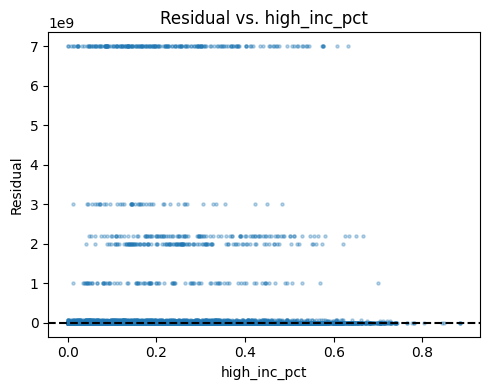

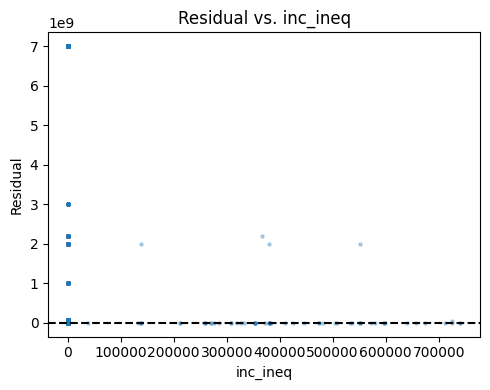

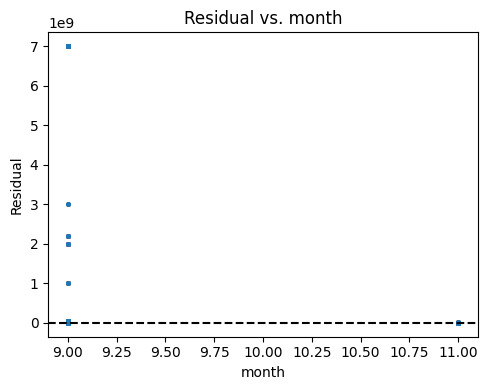

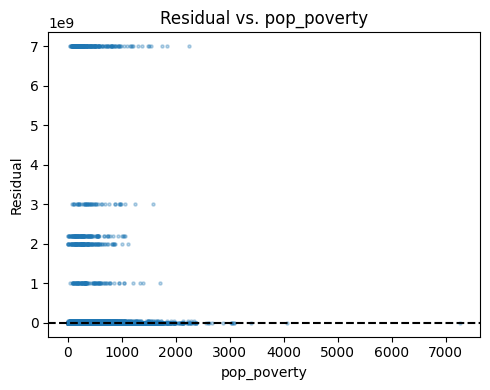

/opt/anaconda3/envs/cos513/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


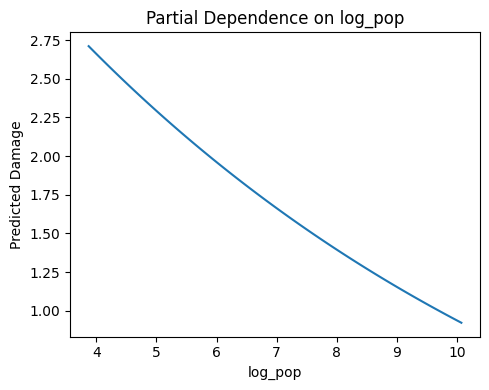

/opt/anaconda3/envs/cos513/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


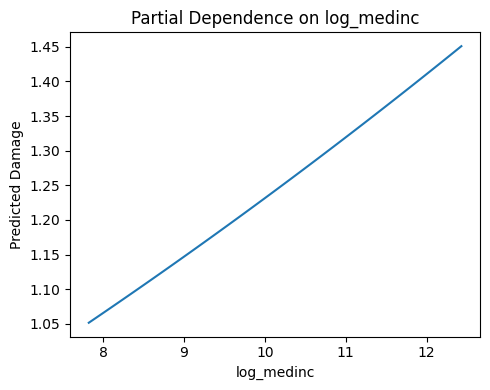

/opt/anaconda3/envs/cos513/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


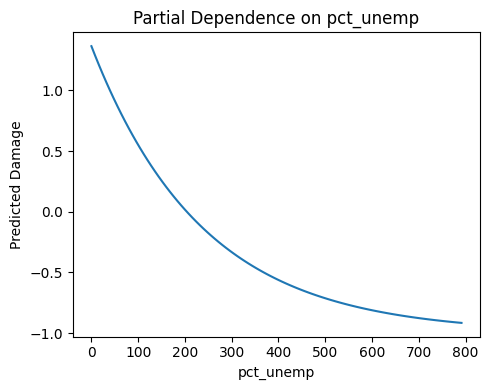

/opt/anaconda3/envs/cos513/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


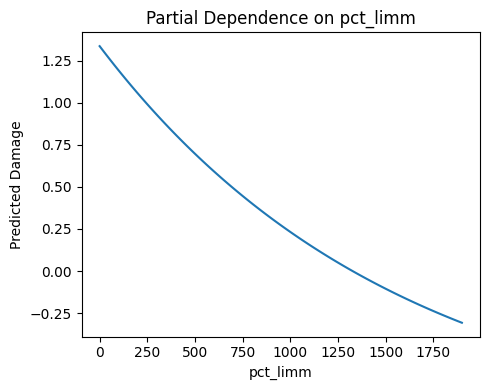

/opt/anaconda3/envs/cos513/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


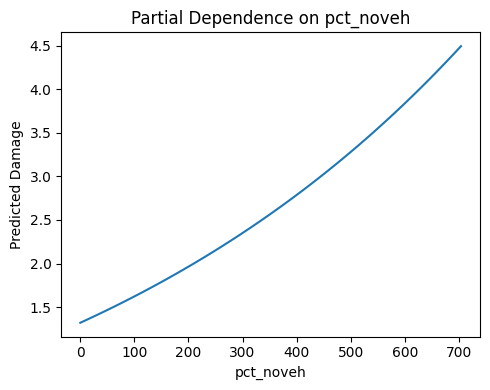

/opt/anaconda3/envs/cos513/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


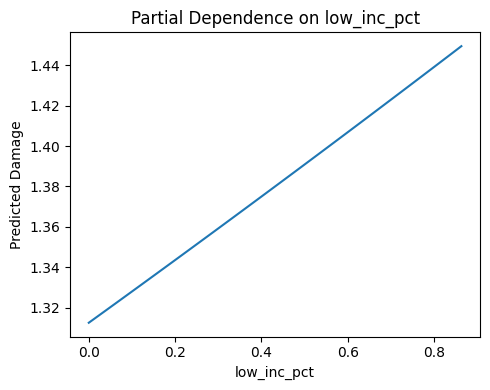

/opt/anaconda3/envs/cos513/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


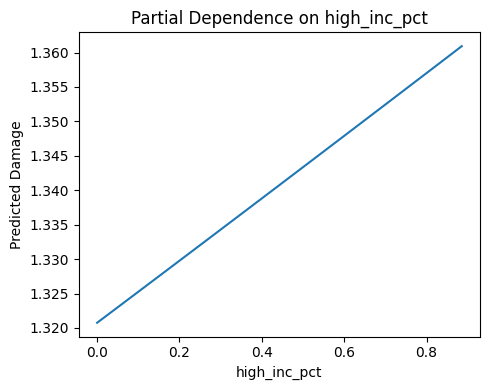

/opt/anaconda3/envs/cos513/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


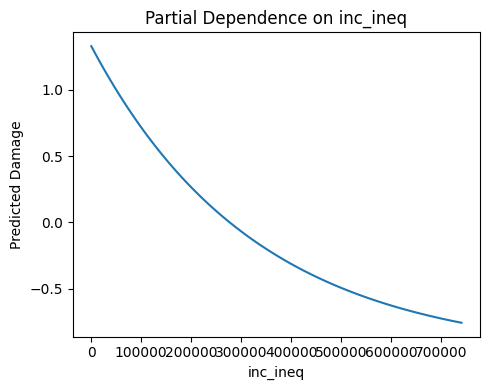

/opt/anaconda3/envs/cos513/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


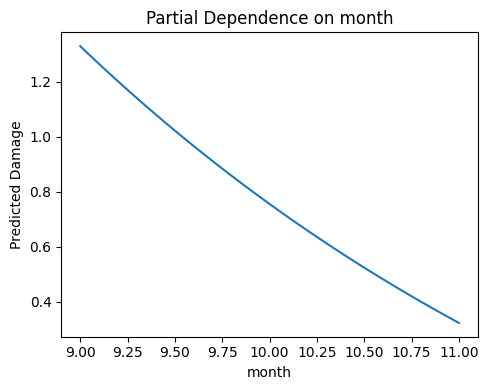

/opt/anaconda3/envs/cos513/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


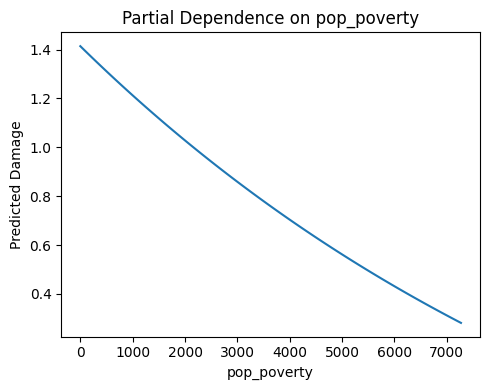

In [26]:
# Posterior “coefficients” bar‐chart
w_loc   = pyro.param("weights_loc").detach().numpy()
w_scale = pyro.param("weights_scale").detach().numpy()
plt.figure(figsize=(6,4))
plt.bar(features, w_loc, yerr=w_scale, capsize=5)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Weight mean ± 1σ")
plt.title("Variational Posterior for Each Feature")
plt.tight_layout()
plt.show()

# Residual vs each feature
# Reconstruct a clean DataFrame for test set
df_test_clean = raw_test.dropna(subset=features + ['Damage to Property','State Abbreviation'])
X_test_df     = df_test_clean[features]
y_true        = df_test_clean['Damage to Property'].values
# point predictions
y_pred = np.expm1(b0 + scaler.transform(X_test_df) @ w_loc)
residuals = y_true - y_pred

for feat in features:
    plt.figure(figsize=(5,4))
    plt.scatter(X_test_df[feat], residuals, alpha=0.3, s=5)
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel(feat)
    plt.ylabel("Residual")
    plt.title(f"Residual vs. {feat}")
    plt.tight_layout()
    plt.show()

# Partial dependence for each feature
median_vals = X_test_df.median().to_dict()
for feat in features:
    grid = np.linspace(X_test_df[feat].min(), X_test_df[feat].max(), 100)
    # build baseline frame
    X_pd = pd.DataFrame({c: median_vals[c] for c in features}, index=range(100))
    X_pd[feat] = grid
    # predict on grid
    y_pd = np.expm1(b0 + scaler.transform(X_pd) @ w_loc)
    plt.figure(figsize=(5,4))
    plt.plot(grid, y_pd)
    plt.xlabel(feat)
    plt.ylabel("Predicted Damage")
    plt.title(f"Partial Dependence on {feat}")
    plt.tight_layout()
    plt.show()

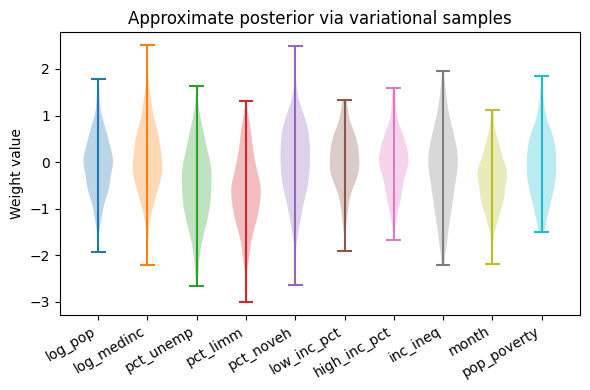

In [18]:
# Weights’ posterior samples (uncertainty)
# sample 200 draws of weights
w_scale = pyro.param("weights_scale").detach().numpy()
w_samples = np.random.normal(w_loc, w_scale, size=(200, len(w_loc)))

plt.figure(figsize=(6,4))
for i, feat in enumerate(features):
    plt.violinplot(w_samples[:,i], positions=[i], widths=0.6)
plt.xticks(range(len(features)), features, rotation=30, ha="right")
plt.ylabel("Weight value")
plt.title("Approximate posterior via variational samples")
plt.tight_layout()
plt.show()
